# 準備

必要なパッケージをインストールする。
```bash
$ conda install -c conda-forge cartopy metpy
```

# 標準大気
高層観測データを扱う前に，国際（米国）標準大気の気温分布をプロットして，matploblibの簡単な使い方について学ぶ。

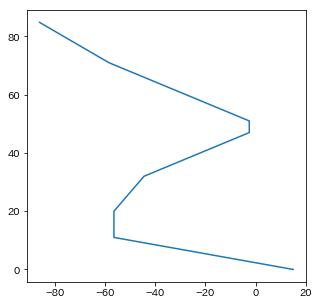

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
T = [15.0, -56.5, -56.5, -44.5, -2.5, -2.5, -58.5, -86.2]
h = [0., 11, 20., 32., 47, 51., 71, 84.852]
ax.plot(T, h)

# 高層気象観測データ
ここでは，[Metpy Air Sounding Tutorial](https://unidata.github.io/MetPy/latest/tutorials/upperair_soundings.html)
に基づいて高層気象観測の解析と描画を行う。

* [ラジオゾンデによる高層気象観測](https://www.jma.go.jp/jma/kishou/know/upper/kaisetsu.html)

## データの取得
[気象庁](http://www.data.jma.go.jp/obd/stats/etrn/upper/index.php)からも，日本の高層気象観測データは取得できるが，扱いにくいので，この実習では[Wyoming大学](http://weather.uwyo.edu/upperair/sounding.html)
にアーカイブされている観測データを取得する。手順は次の通り。

1. [`urlib`](https://docs.python.org/3/library/urllib.request.html)でサーバからデータを取得する。
2. [`Beautifulsoup4`](https://www.crummy.com/software/BeautifulSoup/)でHTMLを解析する。
3. [`io`](https://docs.python.org/3/library/io.html)で文字列をテキストストリームに変換する。
3. [`pandas`](https://pandas.pydata.org)でデータを読み取る。

In [2]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import io
import pandas as pd
url = "http://weather.uwyo.edu/cgi-bin/sounding?region=seasia&TYPE=TEXT%3ALIST&YEAR=2018&MONTH=09&FROM=0400&TO=0400&STNM=47778"
response = urlopen(url)
html = response.read().decode("utf8")
soup = BeautifulSoup(html, "html.parser")
s = soup.pre.string
f = io.StringIO(s)
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']
df = pd.read_fwf(f, skiprows=5, skipfooter=1,
                  usecols=[0, 1, 2, 3, 6, 7], names=col_names)

In [3]:
df

,pressure,height,temperature,dewpoint,direction,speed
0,1000.0,8,NaN,NaN,NaN,NaN
1,990.0,75,27.4,24.7,120.0,24.0
2,972.0,236,26.1,23.8,125.0,47.0
3,925.0,671,22.6,21.4,145.0,54.0
4,850.0,1405,17.8,17.3,155.0,66.0
5,775.0,2192,13.2,12.4,163.0,72.0
6,754.0,2422,12.4,10.9,165.0,74.0
7,700.0,3046,10.4,6.9,165.0,74.0
8,696.0,3094,10.4,5.5,165.0,74.0
9,654.0,3608,6.2,2.1,165.0,78.0


## データの解析

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

In [5]:
df['u_wind'], df['v_wind'] = mpcalc.wind_components(df['speed'], np.deg2rad(df['direction']))
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed',
                       'u_wind', 'v_wind'), how='all').reset_index(drop=True)

In [6]:
p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

持上凝結高度の計算

In [7]:
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
print(lcl_pressure, lcl_temperature)

951.8403007544475 hectopascal 24.04446396516281 degC


上昇気塊の鉛直分布の計算

In [8]:
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

## matplotlibでプロット

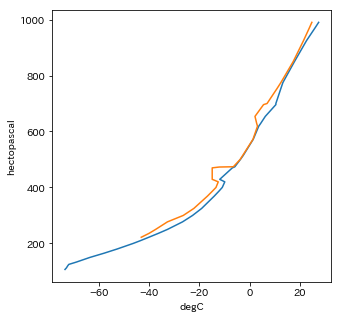

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(T, p)
ax.plot(Td, p)

y軸を対数にし，反転させて，目盛をつける。

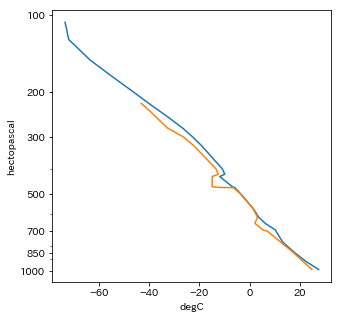

In [10]:
from matplotlib.ticker import ScalarFormatter
fig, ax = plt.subplots(figsize=(5, 5))
ax.semilogy(T, p)
ax.semilogy(Td, p)
ax.set_yticks([1000, 850, 700, 500, 300, 200, 100])
ax.get_yaxis().set_major_formatter(ScalarFormatter())
ax.invert_yaxis()

## 簡単なSkew-T図

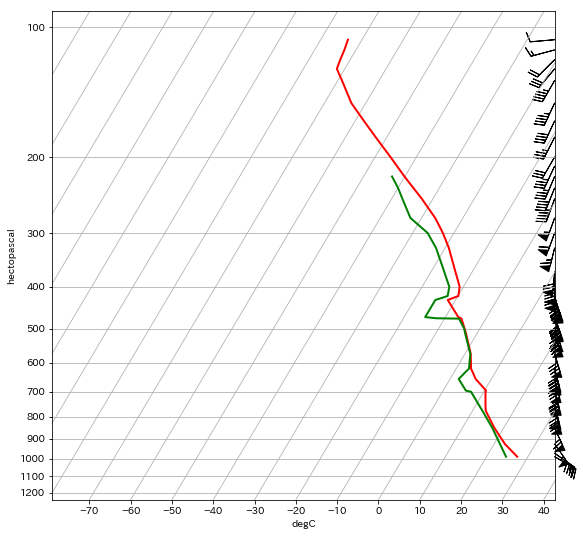

In [11]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

## Skew-T図を完成させる

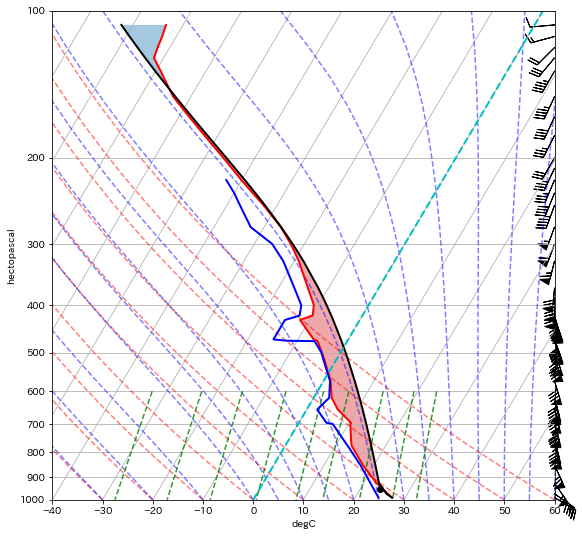

In [12]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'b', linewidth=2)
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
skew.plot(p, parcel_prof, 'k', linewidth=2)
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

## ホドグラフの追加

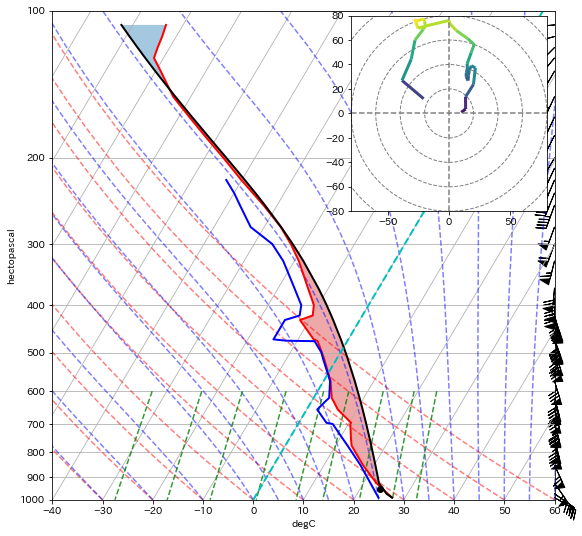

In [13]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'b', linewidth=2)
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
skew.plot(p, parcel_prof, 'k', linewidth=2)
skew.shade_cin(p, T, parcel_prof)
skew.shade_cape(p, T, parcel_prof)
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=80)
h.add_grid(increment=20)
h.plot_colormapped(u, v, wind_speed)

# 関数にまとめる

In [14]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import io
import pandas as pd
def get_sounding(yyyy, mm, dd, hh, stnm):
    url = "http://weather.uwyo.edu/cgi-bin/sounding?TYPE=TEXT%3ALIST&YEAR={0}&MONTH={1:0=2}&FROM={2:0=2}{3:0=2}&TO={2:0=2}{3:0=2}&STNM={4}"
    response = urlopen(url.format(yyyy,mm,dd,hh,stnm))
    html = response.read().decode("utf8")
    soup = BeautifulSoup(html, "html.parser")
    s = soup.pre.string
    f = io.StringIO(s)
    col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']
    df = pd.read_fwf(f, skiprows=5, skipfooter=1,
                      usecols=[0, 1, 2, 3, 6, 7], names=col_names)
    return df

In [15]:
df = get_sounding(2018, 8, 3, 0, 47778)

In [16]:
df

,pressure,height,temperature,dewpoint,direction,speed
0,1001.0,75,28.2,25.8,260,12
1,1000.0,76,27.6,25.3,265,12
2,997.0,103,27.0,25.0,269,12
3,949.0,540,27.6,19.6,332,12
4,932.0,700,27.0,19.0,355,12
5,925.0,767,26.8,18.8,5,12
6,886.0,1147,24.1,16.1,5,4
7,881.0,1197,23.8,15.8,358,5
8,854.0,1469,21.7,15.4,320,10
9,850.0,1510,21.4,15.4,325,10


In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

def plot_sounding(df):
    df['u_wind'], df['v_wind'] = mpcalc.wind_components(df['speed'], np.deg2rad(df['direction']))
    df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed',
                       'u_wind', 'v_wind'), how='all').reset_index(drop=True)
    p = df['pressure'].values * units.hPa
    T = df['temperature'].values * units.degC
    Td = df['dewpoint'].values * units.degC
    wind_speed = df['speed'].values * units.knots
    wind_dir = df['direction'].values * units.degrees
    u, v = mpcalc.wind_components(wind_speed, wind_dir)
    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
    
    parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig)
    skew.plot(p, T, 'r', linewidth=2)
    skew.plot(p, Td, 'b', linewidth=2)
    skew.plot_barbs(p, u, v)
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 60)
    skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
    skew.plot(p, parcel_prof, 'k', linewidth=2)
    skew.shade_cin(p, T, parcel_prof)
    skew.shade_cape(p, T, parcel_prof)
    skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()

    ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
    h = Hodograph(ax_hod, component_range=80)
    h.add_grid(increment=20)
    h.plot_colormapped(u, v, wind_speed)

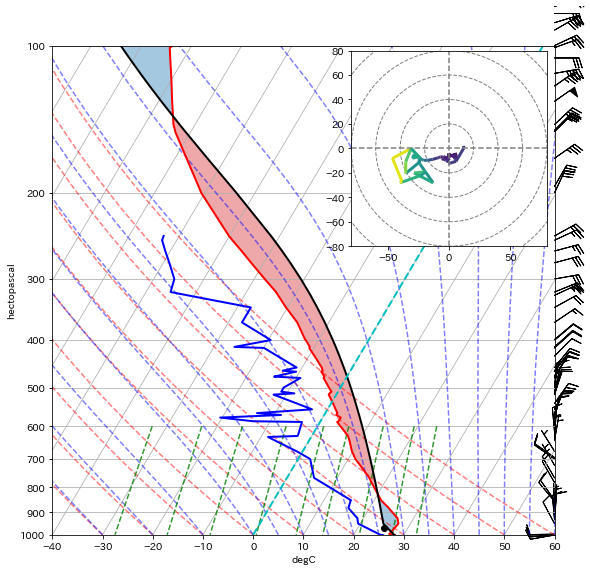

In [18]:
plot_sounding(df)